# Libraries

In [2]:
import csv
import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [3]:
articles = []

dir = "data/energy-geothermal/"
# dir = "data/energy-hydropower/"
# dir = "data/energy-renewable/"
# dir = "data/energy-solar/"
# dir = "data/energy-wind/"

files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Title

        # Set URL and filter URL (Bob Dylan's case)
        url = data[0]["url"]
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue

        # Set entities and filter by number
        entities = data[0]["story_tags"]
        if len(entities) > 100:
            continue  # Filter max
        if len(entities) <= 1:
            continue  # Filter min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            # print('name', name)
            # Remove brackets with text
            cleaned = re.sub(r"\([^()]*\)", "", name)
            name = cleaned
            name = " ".join(name.split())  # Merge multiple spaces
            name = name.lstrip()  # Remove leading whitespaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            # print('name', name)

            if name in {"World Health Organisation"}:
                continue  # Stopwords

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            )  # Add these articles with actors only

    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
).drop_duplicates(
    subset=["url"]
)  # Remove articles with the same URL

print("The number of articles is " + str(articles.shape[0]))

articles.sample(1)


The number of articles is 29


,year,title,url,subjects,orgs,people
25,2022,Bikes get slighted in compromise climate deal,https://www.washingtonpost.com/climate-environ...,"[energy and power, environment]","[Transportation Department, Congress, Joint Co...","[David Zipper, Caron Whitaker, Noa Banayan, Jo..."


## Entities

In [4]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2018: 0,
    2019: 0,
    2020: 0,
    2021: 0,
    2022: 0,
}


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update(entity, "subject")

    for entity in row["orgs"]:
        update(entity, "org")

    for entity in row["people"]:
        update(entity, "person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 359


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
5,environment,subject,20,NaN,None,-1,-1,-1,"{2018: 0, 2019: 3, 2020: 1, 2021: 7, 2022: 9}",[https://www.nytimes.com/2019/08/09/realestate...,"[Converting to Geothermal Energy, The many par...","[David Logsdon, Environmental Protection Agenc..."


# Treatment

## Normalization

In [5]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
34,water,subject,2,NaN,None,-1,-1,-1,"{2018: 0, 2019: 1, 2020: 0, 2021: 1, 2022: 0}",[https://nypost.com/2021/03/22/landowner-wants...,[Landowner wants to build green ‘energy plant’...,"[air pollution, City Hall, energy and power, S...",0.052632,"{""2018"": 0, ""2019"": 1, ""2020"": 0, ""2021"": 1, ""..."


## Filter

In [14]:
# Number of rows by type

max_subjects = 1000
max_orgs = 1000
max_people = 1000

top_subjects = (
    entities_all.loc[entities_all["type"] == "subject"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_subjects)
)
top_orgs = (
    entities_all.loc[entities_all["type"] == "org"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_orgs)
)
top_people = (
    entities_all.loc[entities_all["type"] == "person"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_people)
)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
3,light,subject,15,NaN,None,-1,-1,-1,"{2018: 0, 2019: 3, 2020: 0, 2021: 7, 2022: 5}",[https://www.nytimes.com/2019/08/09/realestate...,"[Converting to Geothermal Energy, Landowner wa...","[David Logsdon, Environmental Protection Agenc...",0.736842,"{""2018"": 0, ""2019"": 3, ""2020"": 0, ""2021"": 7, ""..."


## Linear Regression

In [15]:
# For each

for i, row in entities.iterrows():

    x = list(row["years"].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, "slope"] = slope


# Average and slope difference for subjects

entities_subjects = entities.loc[entities["type"] == "subject"]
average_subjects = entities_subjects["slope"].mean() / 2
for i, row in entities_subjects.iterrows():
    entities.at[i, "slope"] = row["slope"] - average_subjects


# Average and slope difference for people and organizations

entities_nosubjects = entities.loc[entities["type"] != "subject"]
average_nosubjects = entities_nosubjects["slope"].mean() / 2
for i, row in entities_nosubjects.iterrows():
    entities.at[i, "slope"] = row["slope"] - average_nosubjects


# entities.sort_values(by=["slope"], ascending=False).head(1)
# average_subjects, average_nosubjects
entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
158,Tina Tchen,person,1,0.04906,None,-1,-1,-1,"{2018: 0, 2019: 0, 2020: 0, 2021: 1, 2022: 0}",[https://www.nytimes.com/live/2021/05/19/busin...,[Business Updates: Stocks Fall as Crypto’s Dro...,"[Randal K Quarles, Ryan Krause, Fed, European ...",0.0,"{""2018"": 0, ""2019"": 0, ""2020"": 0, ""2021"": 1, ""..."


## Colors

In [16]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] != "subject":
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors
    else:
        entities.at[i, "color"] = "#cccccc"  # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
5,environment,subject,20,2.0,#cccccc,-1,-1,-1,"{2018: 0, 2019: 3, 2020: 1, 2021: 7, 2022: 9}",[https://www.nytimes.com/2019/08/09/realestate...,"[Converting to Geothermal Energy, The many par...","[David Logsdon, Environmental Protection Agenc...",1.0,"{""2018"": 0, ""2019"": 3, ""2020"": 1, ""2021"": 7, ""..."


# Embedding

## Term Frequency

In [17]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


## UMAP

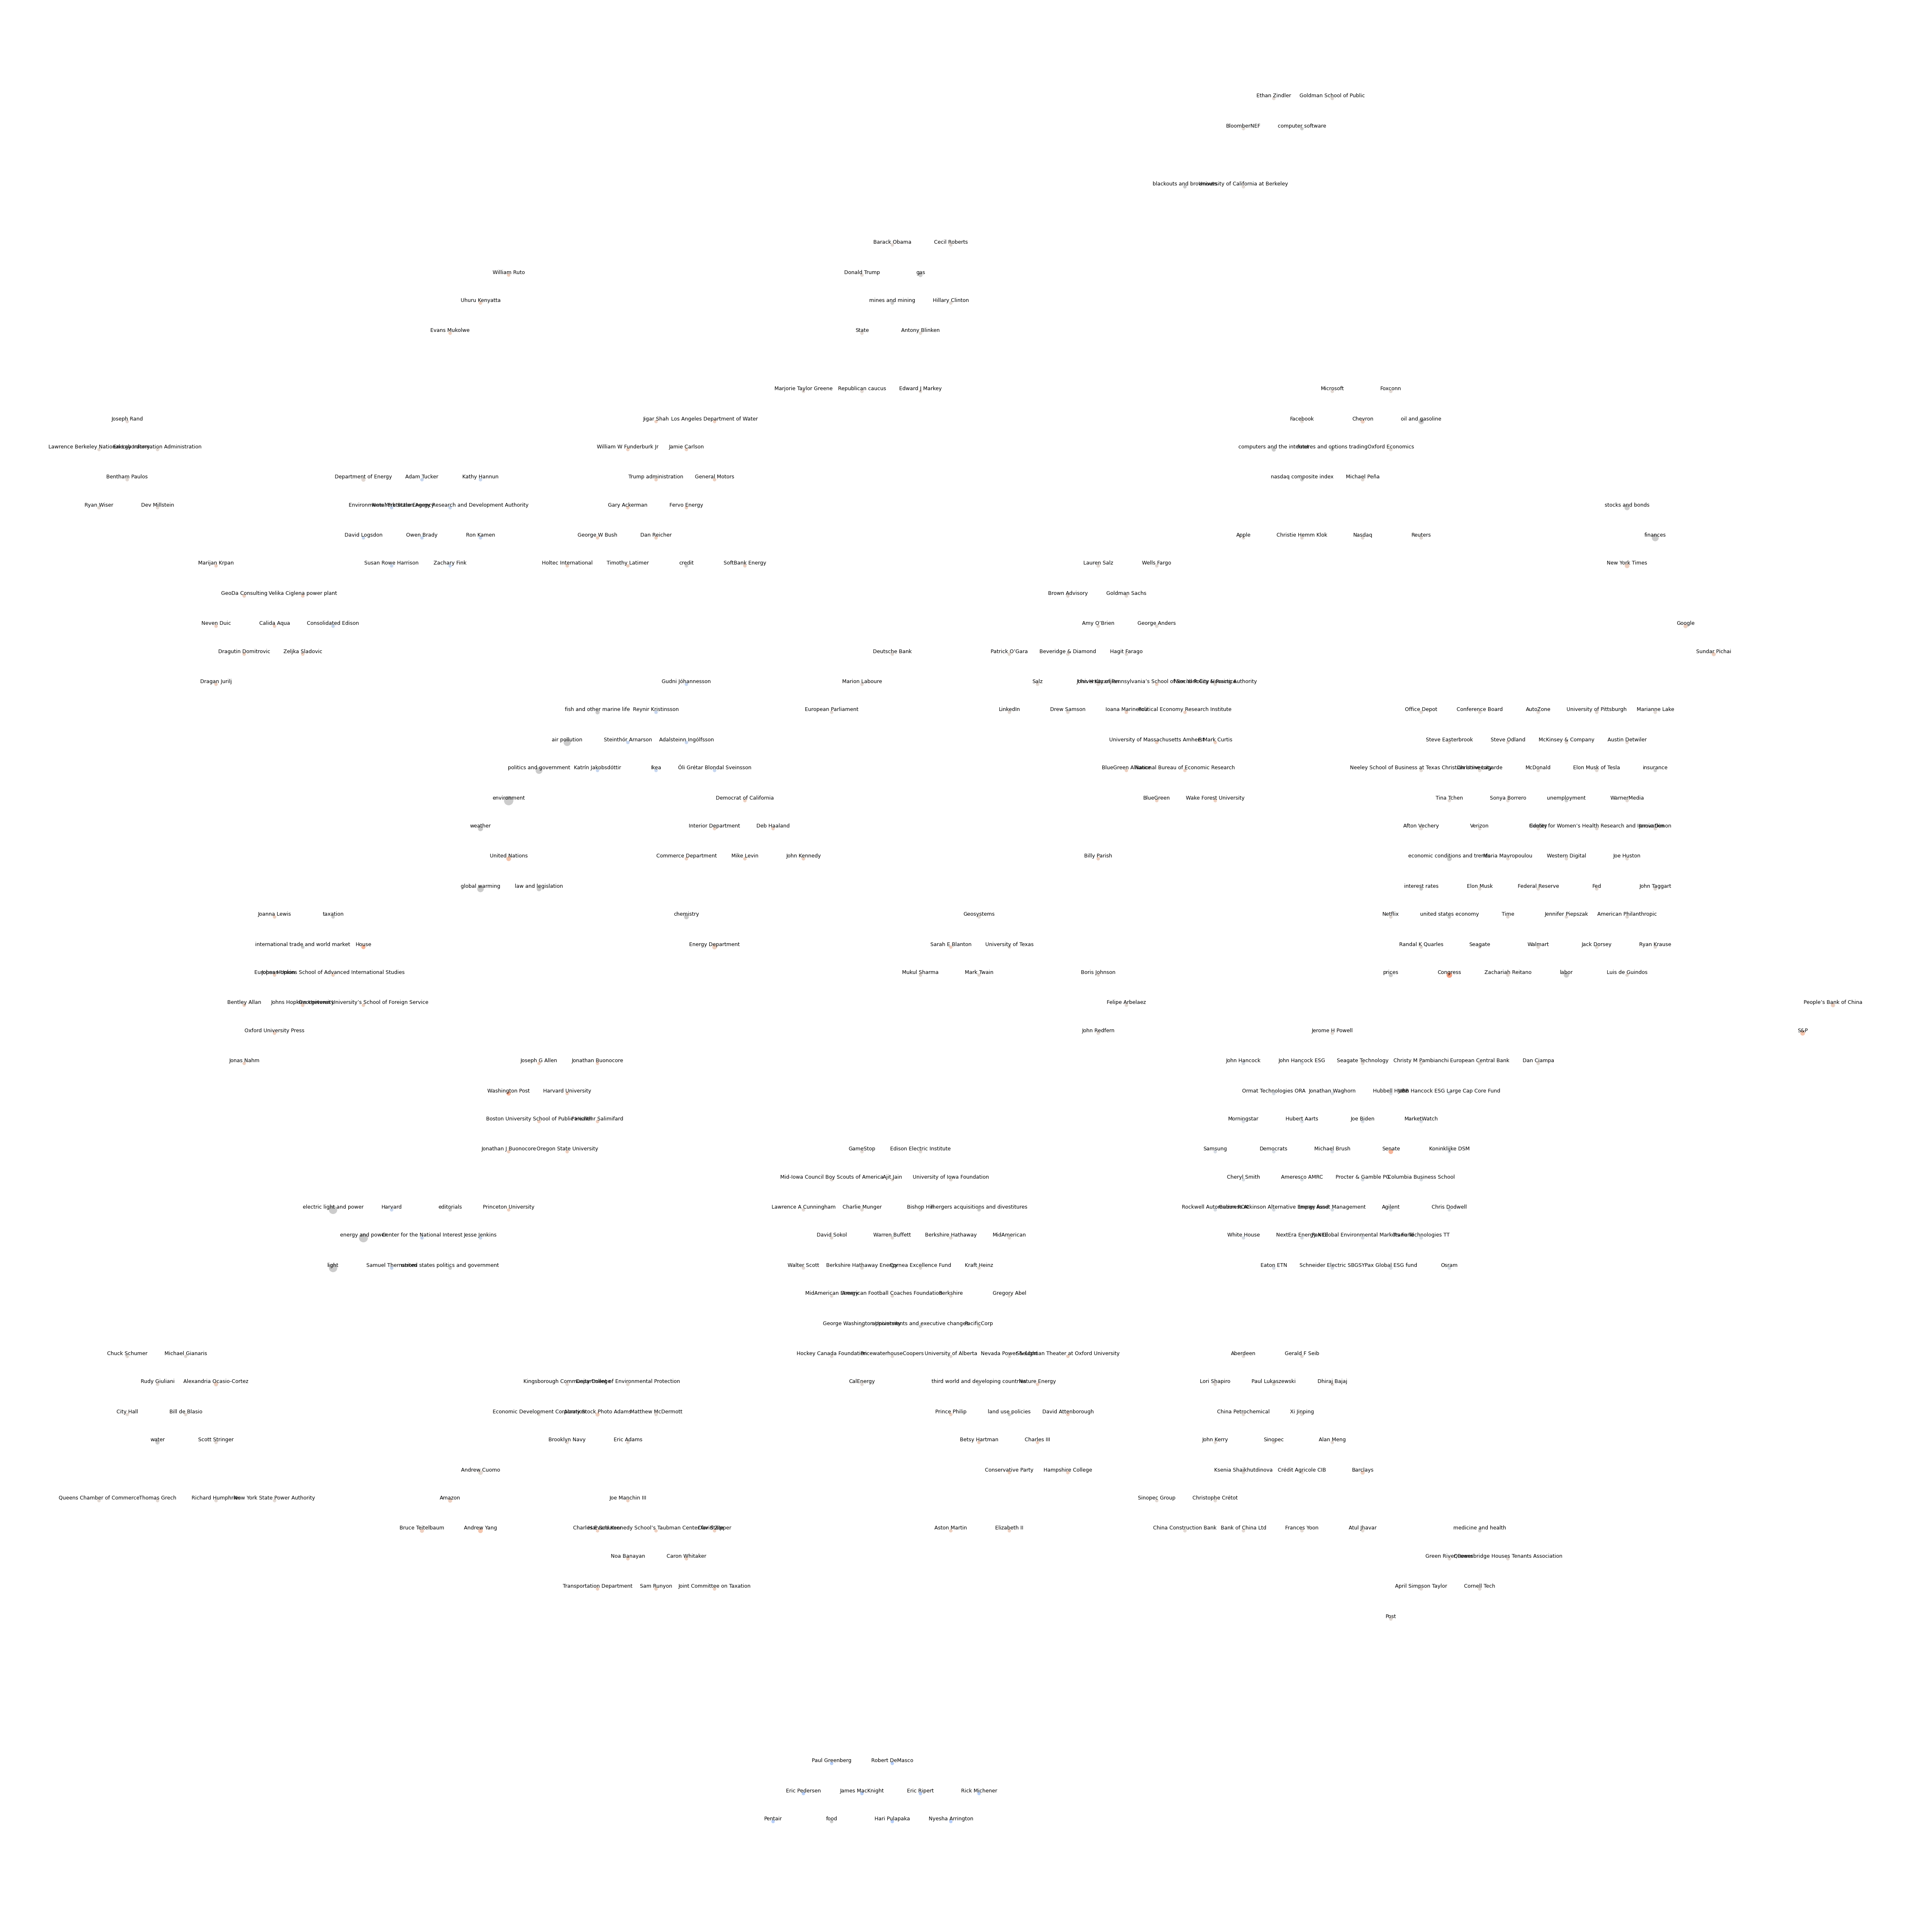

In [18]:
reducer = umap.UMAP(
    random_state=4,
    n_components=2,
    n_neighbors=2,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [19]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
181,John Kerry,person,1,0.04906,#e3d9d3,615,276,p_9,"{2018: 0, 2019: 0, 2020: 0, 2021: 1, 2022: 0}",[https://www.wsj.com/articles/chinas-green-bon...,[China's 'Green Bonds' Often Look More Like Re...,"[Crédit Agricole CIB, air pollution, S&P, Fran...",0.0,"{""2018"": 0, ""2019"": 0, ""2020"": 0, ""2021"": 1, ""..."


{'p_4', 'p_5', 'n_0', 'p_7', 'p_2', 'p_8', 'p_11', 'n_3', 'p_14', 'p_15', 'p_10', 'p_3', 'p_6', '-1', 'n_1', 'n_2', 'p_1', 'n_4', 'p_9', 'p_0', 'p_13', 'p_12'}
49
36
9
9
11
4
7
7
7
24
14
20
9
51
31
4
17
10
18
4
10
8


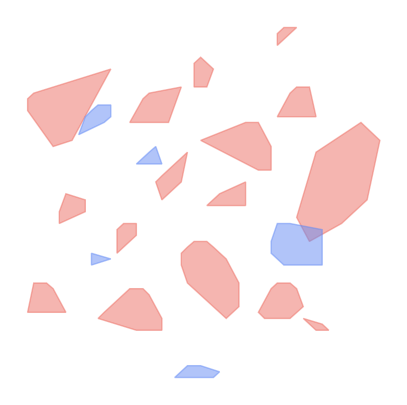

In [20]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [21]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
308,Michael Peña,person,1,0.04906,#e3d9d3,683,723,p_13,[https://www.nytimes.com/live/2021/05/18/busin...,0.0,"{""2018"": 0, ""2019"": 0, ""2020"": 0, ""2021"": 1, ""..."
